# Motivation

This section will cover the motivation and idea behind choosing the topic of overfishing and explain which datasets are used and why.


## Problem statement (Goal for end user)

People are already aware of the general story on overfishing, even Netflix has jumped the bandwagon and produced documentaries such as _Seaspiracy_. However, such documentaries seem to mislead the audience [ref](https://www.theguardian.com/environment/2021/mar/31/seaspiracy-netflix-documentary-accused-of-misrepresentation-by-participants) due to over-dramatization. Moreover, most people think of fish as bad for the environment and our world sustainability goals, so they tend to avoid them all together, for example by becoming a vegetarian or vegan.


> What we aim to show, is a sound and objective analysis of unsustainable fishing activities. Providing insights into the best and worst ways of the fishing industry by analysing two particularly interesting countries: China and Norway. Finally, using our analysis, we discuss whether eating fish is a viable option for steady protein supply.



## Datasets

In terms of datasets, we use a wide variety of different datasets to compose our story.

### FAO

The **main** source of data is from _Food and Agriculture Organization of the United Nations_ at the url [https://www.fao.org/home/en](https://www.fao.org/home/en). The organization provides access to a massive database with anything related to food and agricultural data in the world.
Our requirements for the dataset was to have data for most countries (and further on, only Norway and China), some temporal information (years) and come from a credible source.
This yielded the datasets from FAO:

- Fishing industry (import, export, supply, production)
- Fish and seafood consumption per capita
- Sources of consumed protein
- Fishing methods

### Additional sources

Another source of data was the world bank [https://datacatalog.worldbank.org/search/dataset/0037712](https://datacatalog.worldbank.org/search/dataset/0037712)
This gave access to the trend and development of open-ocean fishing versus aquacultural fishing.

Additionally, we were able to get information on the GHG (Greenhouse Gas) emission of aquacultural fishing from [https://www.nature.com/articles/s41586-021-03889-2](https://www.nature.com/articles/s41586-021-03889-2)
### Descriptive data

Finally, we also made use of other third-party datasets that made it easier for us to gather information on a country's GDP and population each year.

In order to join this descriptive data with the main datasets, we had to find a common connection between them. Going by just the country name is risky as some countries go by more than one name and others simply have different spellings. Therefore, we used the country ISO-3 code that is _the_ standard for identifying countries. By merging this mapping onto any dataset using the country name (and making a few manual changes). We were able to get an ISO-3 standardized country code for each dataset that needed to be merged with other data.

Another addition to the descriptive data is the use of a **geojson** file that is used for the choropleth maps. However, the original file was too complex (too many polygons) and therefore took a lot of time to plot and render. We therefore decided to simplify the geojson using an online tool such that we ensure that we maintain interpretability and a high enough resolution for the polygons to overlap correctly with the country borders.

## Why did we choose these datasets

Choosing datasets for this project was not easy as it's difficult to find data that covers information on specific fishing related topics such as fishing gear, emission of aquacultural fish, protein supply for each country and so on. Even more so, it was painful to find data with a temporal aspect over multiple years. This resulted in us fetching data from many different sources after searching through a large amount of infeasible datasets.

We find that the selected datasets are useful because they are a combination of being rich in information (covers many metrics over many countries with few NaN values), covering multiple years of data, cover extremely niche or rare data.

The combination of the datasets provide us with an opportunity to explore overfishing on a global scope as well as diving into the specific methods of China and Norway. Moreover, they also contain information on eating habits in terms of protein supply which helps in analysing both the behaviour of the population and the demand of fish.

# Basic Stats

This section will cover the steps we took in terms of processing the data. Much of the code will be from snippets of the functions in `plots/data`. For brevity's sake, we will try to summarize the key points (across datasets) instead of going into extreme detail for each of the 11 different datasets.

## Choices in data cleaning and preprocessing



### Creating a common key across datasets

As mentioned previously, since we use many different datasets. It's important to have a common key when joining the data together on both countries and year.

For this reason we used the `country_code_map.csv` file.

In [3]:
import pandas as pd

In [4]:
pd.read_csv('data/country_code_map.csv').head(2)

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""


Using the `Country` and the `Alpha-3 Code` (ISO-3) we are able to map country names to country codes. We usually make use of the function below to retrieve the data.

In [5]:
# Defining the country code map. For this case, we over-comment the code for the purpose of the explainer notebook.
def get_country_code_map():
    """
    Retrieve the mapping between country names to country codes and vice versa

    """
    # Select only the relevant columns
    country_code_map = pd.read_csv('data/country_code_map.csv')[['Country', 'Alpha-3 code']]

    # Remove double quotes from the code
    country_code_map['Alpha-3 code'] = country_code_map['Alpha-3 code'].apply(lambda x: x.split('"')[1])

    # Set country as index and convert to dictionary in form of [index] -> [{column: value}]
    country_code_map = country_code_map.set_index('Country').to_dict(orient='index')

    # Reverse dictionary
    country_code_to_country = {value['Alpha-3 code']: key for key, value in country_code_map.items()}
    return country_code_map, country_code_to_country


country_code_map, country_code_to_country = get_country_code_map()
print(f"Country to code map 'Denmark': {country_code_map['Denmark']}")
print(f"Map to country map 'DNK': {country_code_to_country['DNK']}")

Country to code map 'Denmark': {'Alpha-3 code': 'DNK'}
Map to country map 'DNK': Denmark


After retrieving the mapping, we add the keys to the dataset. Some datasets have only country names but no codes, and others the otherway around. For the datasets with only country names, we had to manually map some of the country names to the equivalent name in the mapping dictionary. An example of such is seen below. We will comment the special cases but not more than once.

In [6]:
def get_industry_data():
    df = pd.read_csv('data/FAOSTAT_country_supply_production_import_export.csv')
    df.loc[df['Area'] == "China, mainland", 'Area'] = 'China'  # Generalize to China
    df.loc[df['Area'] == 'China, Hong Kong SAR', 'Area'] = 'China'
    df.loc[df['Area'] == 'China, Macao SAR', 'Area'] = 'China'
    df.loc[df['Area'] == "China, Taiwan Province of", 'Area'] = 'Taiwan'  # Taiwan on it's own
    df.loc[df['Area'] == "C?te d'Ivoire", 'Area'] = "Côte d'Ivoire"  # Special characters
    df.loc[df['Area'] == "Netherlands Antilles (former)", 'Area'] = "Netherlands"  # Longer names
    df.loc[df['Area'] == 'Bolivia (Plurinational State of)', 'Area'] = "Bolivia"  # No parenthesis
    df.loc[df['Area'] == 'Cabo Verde', 'Area'] = "Cape Verde"  # Different names for one country
    df.loc[df['Area'] == 'Czechia', 'Area'] = "Czech Republic"
    df.loc[df['Area'] == "Democratic People's Republic of Korea", 'Area'] = "South Korea"  # Common name rather than formal name
    df.loc[df['Area'] == 'Democratic Republic of the Congo', 'Area'] = "Congo"
    df.loc[df['Area'] == 'Eswatini', 'Area'] = "Swaziland"
    df.loc[df['Area'] == 'Iran (Islamic Republic of)', 'Area'] = "Iran, Islamic Republic of"
    df.loc[df['Area'] == 'North Macedonia', 'Area'] = "Macedonia, the former Yugoslav Republic of"
    df.loc[df['Area'] == 'Republic of Korea', 'Area'] = "Korea, Republic of"  # Reverse naming. Country name before title: country, title
    df.loc[df['Area'] == 'United Kingdom of Great Britain and Northern Ireland', 'Area'] = "United Kingdom"
    df.loc[df['Area'] == 'Republic of Moldova', 'Area'] = "Moldova, Republic of"
    df.loc[df['Area'] == 'United Republic of Tanzania', 'Area'] = "Tanzania, United Republic of"
    df.loc[df['Area'] == 'United States of America', 'Area'] = 'United States'
    df.loc[df['Area'] == 'Venezuela (Bolivarian Republic of)', 'Area'] = 'Venezuela, Bolivarian Republic of'

    # df = add_population(df)   # Out commented for explainer-notebook purposes
    return df

### Adding population data

After finding common keys across datasets, we add the population data for a given year which enables us to calculate any metric per capita: $metric\_per\_capita = \frac{metric}{population}$

In [7]:
def get_population():
    return pd.read_csv('data/population_total.csv')

In [8]:
def add_population(df, country_col='Area'):
    # Get data
    df_population = get_population()
    country_code_map, country_code_to_country = get_country_code_map()

    # Add the country code if it's not present in the dataframe
    if 'Country Code' not in df.columns:
        df['Country Code'] = df.apply(lambda x: country_code_map[x[country_col]]['Alpha-3 code'], axis=1)

    # Kind of advanced data wrangling operation, inspired from the Tidy data paradigm.
    # We give a brief introduction, but please look up the proper documentation if you don't understand the function.
    # Melting a dataframe is useful when we have a variable, such as 'Year' expanded over multiple columns.
    # For example the columns in a dataframe could be: [Country Name, Country Code, 2010, 2011, 2012, ... 2022]
    # Where each value in the 'Year' columns is a variable such as 'population'.
    # Melting the dataframe takes all the columns NAMES defined in 'value_vars' and assigns them to a single column
    # with the name: 'var_name' which in this case is 'Year'. Example var_name = pd.Series([2010, 2011, 2012, ..., 2022])
    # The corresponding value in that column is then assigned to another column in 'value_name'. The pairs of
    # [var_name, value_name] are then identical to what was previously in column format, however it is now only in row format.
    melted = pd.melt(df_population, id_vars=['Country Name', 'Country Code'], value_vars=df_population.columns[2:],
                     var_name='Year',
                     value_name='population')

    # Set year as integer to make them joinable
    melted.Year = melted.Year.astype(int)

    # Final merge operatoin
    df = pd.merge(melted, df, on=['Country Code', 'Year'])
    return df

After running the above function, there is a value of population for each country on each year.

In [9]:
df = get_industry_data()
add_population(df, country_col='Area').sample(4).iloc[:, :4]

,Country Name,Country Code,Year,population
35438,Chile,CHL,2016,18209072.0
42823,"Iran, Islamic Rep.",IRN,2017,80673888.0
54509,Italy,ITA,2019,59729081.0
14851,Madagascar,MDG,2012,22346641.0


### Data quality (NaN values and outliers)

#### Missing values
Missing values were investigated for all datasets. However, most of the datasets luckily did not show significant signs of poor quality in terms of NaN values.
In cases where there were NaN values, it was often in context of a visualization such as when plotting the consumption map. However, when plotting the map with NaN values,
it is a benefit as the countries are **kept out** of the map which is the same as dropping that particular row. If we would have imputed the value with for example: 0, it would've been manipulated data and perhaps lead to misinterpretations.

In [10]:
from plots.data import get_consumption

df = get_consumption()
df.drop('TotalC', axis=1, inplace=True)
df[df.isna().any(axis=1)].sample(5)

,country,Code,Year,consumption
7415,Northern Africa,NaN,2009,11.09
6429,Middle Africa,NaN,1984,16.36
7515,Northern Europe,NaN,2003,23.77
5427,Least Developed Countries,NaN,1979,7.01
2849,Eastern Europe,NaN,1962,12.57


In [11]:
df[df.isna().any(axis=1)].country.unique()[:10]

array(['Africa', 'Americas', 'Asia', 'Asia, Central',
       'Australia & New Zealand', 'Belgium-Luxembourg', 'Caribbean',
       'Central America', 'Eastern Africa', 'Eastern Asia'], dtype=object)

It's seen that there are some countries that have missing country codes, but this is no issue for plotting. Moreover, we use the a custom _geojson_ to plot the maps, meaning that the regions such as (Africa, Americas, Asia, Europe, ...) will be left out as they aren't in the geojson.

In [12]:
import json

with open('data/countries-simplified.json') as response:
    countries = json.load(response)

countries['features'][0]['properties']

{'ADMIN': 'Aruba', 'ISO_A3': 'ABW', 'ISO_A2': 'AW'}

As you can see, we use the ISO_A3 (ISO Alpha 3) code to map countries and the geojson together. The ISO3 codes are in the consumption dataset, but _not_ in the industry dataset, which is why we add the country codes to it using the mapping. As without any country codes, we wouldn't be able to plot a choropleth map of the fishing industry

#### Outliers

Outliers didn't cause much trouble either. Except for one place when working with the scale of the colorbar in the consumption map. Let's take a look at the code. We WONT plot the map here as it takes up 150 Mb in the offline version.

In [13]:
from utils.decorator import style_plot
import plotly.express as px


@style_plot
def plot_consumption_map(df):
    with open('data/countries-simplified.json') as response:
        countries = json.load(response)

    # OUTLIERS!
    range_color = (0, df.consumption.quantile(0.99))
    # OUTLIERS!

    map_args = dict(
        geojson=countries,
        featureidkey='properties.ISO_A3',
        locations="Code",
        color="consumption",  # lifeExp is a column of gapminder
        hover_name="country",  # column to add to hover information
        animation_frame='Year',
        mapbox_style="carto-positron",
        color_continuous_scale='YlOrRd',
        range_color=range_color,
        title='Fish consumption (kg / capita) from 1961 to 2017',
        center={'lat': 12, 'lon': 5}
    )

    fig = px.choropleth_mapbox(df, zoom=0.5, **map_args)
    # More styling code below but it's been left out for brevity's sake.

As seen in line 10 of the cell above, we have adjusted the color of the range from 0 to 99% quantile. This is due to few extreme outliers that make identifying other high-consumption countries difficult. Let's take a look at the outliers.

In [14]:
df = get_consumption()

df.consumption.describe()

count    11028.000000
mean        16.670872
std         17.056281
min          0.000000
25%          5.340000
50%         11.995000
75%         22.512500
max        191.750000
Name: consumption, dtype: float64

The maximum value is 191 whilst the 75% quantile is only 22.5!! The data is clearly skewed.

<AxesSubplot:>

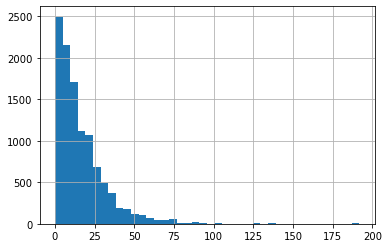

In [15]:
# Very simple plot for illustrative purposes.
df.consumption.hist(bins=40)

<AxesSubplot:>

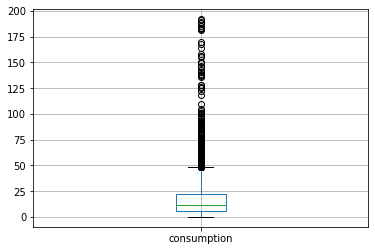

In [16]:
df.boxplot(column='consumption')

The 99% quantile is then

In [17]:
df.consumption.quantile(0.99)

75.34459999999999

Which is MUCH more reasonable when looking at the plots above as well.

**Industry dataset outliers**

We replicated the method above for the Industry dataset (import, export, production and supply) as well, however we don't find the need to replicate the whole process and analysis again (as it's copy paste with different a different dataset).
The resulting relevant quantile for the Industry dataset turned out to be 0.975 due to the same reasons above (extreme outliers).

**Other datasets**

With respect to the other datasets we didn't find any significant outliers that hindered the analysis or visualization.

## Dataset stats and key points

We have already touched upon the outlier and NaN value detection and corresponding mitigation techniques.

Here we will go over some descriptive statistics on our datasets, and present some key points of the exploratory analysis that lead us to the final visualizations found on the website.

Since we are working with multiple datasets, we will focus on the ones that have the highest data quality and information.

> Note: From now we will use some of our functions to get data and perform the plotting. We do this to save space and focus on plots and text rather than code. You can always find the code by following the import path (or use an IDE)

### Data summary and Descriptive statistics

In this section we will provide insights and examples from the datasets and
also perform some descriptive statistics.

Generally, we will keep the analysis brief as there are a lot of datasets to cover.
This is the only time we'll be showcasing all 11 datasets.

This section is meant to give the reader a quick overview of what each dataset used in this project contains.

#### Country Code Mappings

In [18]:
country_code_map = pd.read_csv('data/country_code_map.csv')[['Country', 'Alpha-3 code']]
country_code_map.describe()

,Country,Alpha-3 code
count,256,256
unique,256,244
top,Afghanistan,"""VCT"""
freq,1,3


In [19]:
country_code_map.head()

,Country,Alpha-3 code
0,Afghanistan,"""AFG"""
1,Albania,"""ALB"""
2,Algeria,"""DZA"""
3,American Samoa,"""ASM"""
4,Andorra,"""AND"""


In [20]:
country_code_map.Country.unique().tolist()[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina']

As we can see, the country code mapping is almost what one would expect. Given the country name there is a corresponding country code.

One interesting thing to look at is the fact that there are `256` unique countries but only `244` unique country codes. Meaning some countries map to the same country code. Let's have a look

In [21]:
country_code_map[country_code_map['Alpha-3 code'].duplicated()]

,Country,Alpha-3 code
26,Bolivia,"""BOL"""
33,Brunei,"""BRN"""
55,Ivory Coast,"""CIV"""
119,South Korea,"""KOR"""
128,Libya,"""LBY"""
155,Burma,"""MMR"""
187,Russia,"""RUS"""
194,Saint Vincent & the Grenadines,"""VCT"""
195,St. Vincent and the Grenadines,"""VCT"""
222,Taiwan,"""TWN"""


In [22]:
country_code_map[country_code_map['Alpha-3 code'] == ' "BOL"']

,Country,Alpha-3 code
25,"Bolivia, Plurinational State of","""BOL"""
26,Bolivia,"""BOL"""


In [23]:
country_code_map[country_code_map['Alpha-3 code'] == ' "MMR"']

,Country,Alpha-3 code
154,Myanmar,"""MMR"""
155,Burma,"""MMR"""


It seems that it is just multiple names for a country that maps to the Alpha-3 code. The case of Bolivia is quite obvious.
The case of Myanmar is not so much. The significant difference in name is due to the country being occupied by the British empire which gave the name _Burma_.
After becoming independent, they decided to change the name to _Myanmar_ for cultural reasons [ref](https://en.wikipedia.org/wiki/Names_of_Myanmar)

#### Population

In [24]:
df_pop = get_population()
df_pop.columns

Index(['Country Name', 'Country Code', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020'],
      dtype='object')

In [25]:
df_pop.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,...,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02
mean,1.173116e+08,1.188586e+08,1.209679e+08,1.235882e+08,1.262297e+08,1.289366e+08,1.317868e+08,1.346309e+08,1.375436e+08,1.405603e+08,...,2.828664e+08,2.866170e+08,2.904120e+08,2.942198e+08,2.980198e+08,3.018343e+08,3.056619e+08,3.094099e+08,3.130784e+08,3.166573e+08
std,3.705555e+08,3.749081e+08,3.814322e+08,3.899277e+08,3.984666e+08,4.072394e+08,4.165735e+08,4.258523e+08,4.353820e+08,4.452976e+08,...,8.906976e+08,9.017794e+08,9.129557e+08,9.241202e+08,9.352185e+08,9.463293e+08,9.574907e+08,9.683242e+08,9.788601e+08,9.890355e+08
min,2.833000e+03,3.077000e+03,3.367000e+03,3.703000e+03,4.063000e+03,4.460000e+03,4.675000e+03,4.922000e+03,5.194000e+03,5.461000e+03,...,1.006900e+04,1.013600e+04,1.020800e+04,1.028900e+04,1.037400e+04,1.047400e+04,1.057700e+04,1.067800e+04,1.076400e+04,1.083400e+04
25%,5.022802e+05,5.109642e+05,5.206540e+05,5.311622e+05,5.421252e+05,5.533362e+05,5.647475e+05,5.823645e+05,5.981078e+05,6.100030e+05,...,1.562996e+06,1.604981e+06,1.648259e+06,1.692433e+06,1.737207e+06,1.777557e+06,1.791003e+06,1.797085e+06,1.788878e+06,1.775378e+06
50%,3.718330e+06,3.826398e+06,3.929109e+06,4.015834e+06,4.124521e+06,4.242788e+06,4.326013e+06,4.387887e+06,4.474171e+06,4.550402e+06,...,9.461643e+06,9.729254e+06,9.893082e+06,9.866468e+06,1.016003e+07,1.032545e+07,1.030030e+07,1.028382e+07,1.028626e+07,1.035344e+07
75%,2.636053e+07,2.721235e+07,2.808607e+07,2.890669e+07,2.972333e+07,3.055227e+07,3.134845e+07,3.200449e+07,3.244145e+07,3.277149e+07,...,5.937945e+07,5.953972e+07,6.023395e+07,6.078914e+07,6.073058e+07,6.062750e+07,6.053671e+07,6.042176e+07,5.972908e+07,5.973421e+07
max,3.032156e+09,3.071596e+09,3.124561e+09,3.189656e+09,3.255146e+09,3.322047e+09,3.392098e+09,3.461620e+09,3.532783e+09,3.606554e+09,...,7.003760e+09,7.089255e+09,7.175500e+09,7.261847e+09,7.347679e+09,7.433569e+09,7.519183e+09,7.602454e+09,7.683372e+09,7.761620e+09


In [26]:
df_pop[['Country Name', 'Country Code']]

,Country Name,Country Code
0,Aruba,ABW
1,Africa Eastern and Southern,AFE
2,Afghanistan,AFG
3,Africa Western and Central,AFW
4,Angola,AGO
...,...,...
261,Kosovo,XKX
262,"Yemen, Rep.",YEM
263,South Africa,ZAF
264,Zambia,ZMB


As we can see, the population is just the population of a country in a given year. Strangely enough, the year variable is expanded over columns. This gave rise to the data preprocessing detailed above.

#### Industry data

In [27]:
df_industry = pd.read_csv('data/FAOSTAT_country_supply_production_import_export.csv')
df_industry.columns

Index(['Domain Code', 'Domain', 'Area Code (FAO)', 'Area', 'Element Code',
       'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')

In [28]:
df_industry['Element'].unique()

array(['Production', 'Import Quantity', 'Domestic supply quantity',
       'Export Quantity'], dtype=object)

The industry data contains information on the Production, Import Quantity, Domestic supply quantity, and Export Quantity.

The four quantities are related by:

$$
\text{production} + \text{import} = \text{supply} + \text{export}
$$

The Domestric supply quantity is what's left over in the country after exporting

In [29]:
df_industry.describe()

,Area Code (FAO),Element Code,Item Code,Year Code,Year,Value
count,58100.000000,58100.000000,58100.000000,58100.000000,58100.000000,58100.000000
mean,128.613253,5577.241824,2788.507470,2014.505938,2014.505938,201.714659
std,73.994864,221.571138,64.284051,2.871461,2.871461,1842.178378
min,1.000000,5301.000000,2761.000000,2010.000000,2010.000000,0.000000
25%,67.000000,5301.000000,2763.000000,2012.000000,2012.000000,0.090000
50%,123.000000,5611.000000,2765.000000,2015.000000,2015.000000,2.520000
75%,191.000000,5611.000000,2767.000000,2017.000000,2017.000000,34.930000
max,351.000000,5911.000000,2960.000000,2019.000000,2019.000000,67902.890000


Interestingly, the `Value` column seems to have an incredibly large standard deviation (`1842`) wrt the mean (`202`). Let's investigate

<AxesSubplot:>

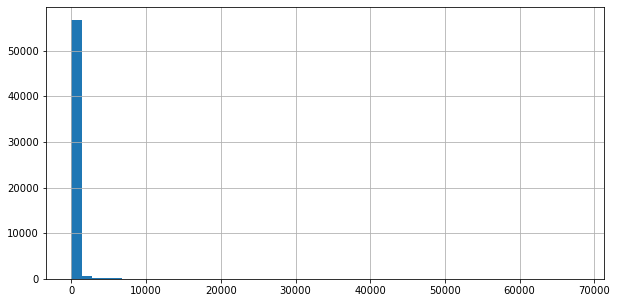

In [30]:
df_industry['Value'].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

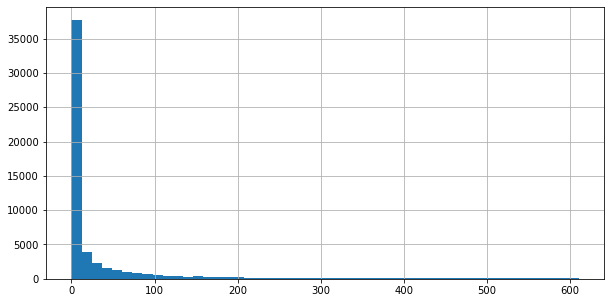

In [31]:
df_industry[df_industry.Value <= df_industry['Value'].quantile(0.95)]['Value'].hist(bins=50, figsize=(10, 5))

As we can see, the value column is extremely skewed, even when only looking at the $95\%$ percentile.

This should be kept in mind if modelling this value as some, for example linear, models assume normal distribution of residuals, which will be difficult in this case for linear regression.

#### Consumption


In [32]:
df_consumption = pd.read_csv("data/fish-and-seafood-consumption-per-capita.csv")
df_consumption.drop('TotalC', axis=1, inplace=True)
df_consumption.columns

Index(['Entity', 'Code', 'Year',
       'Fish, Seafood- Food supply quantity (kg/capita/yr) (FAO, 2020)'],
      dtype='object')

In [33]:
df_consumption.describe()

,Year,"Fish, Seafood- Food supply quantity (kg/capita/yr) (FAO, 2020)"
count,11028.000000,11028.000000
mean,1989.461824,16.670872
std,16.320065,17.056281
min,1961.000000,0.000000
25%,1975.000000,5.340000
50%,1990.000000,11.995000
75%,2004.000000,22.512500
max,2017.000000,191.750000


We have seen this table before and will refer to section on **Basic Stats > Choices in data cleaning and preprocessing > Data quality > Outliers** for a detailed analysis.

#### Sustainability levels

In [34]:
sustainable = pd.read_csv('data/fish-stocks-within-sustainable-levels.csv')
sustainable.columns

Index(['Entity', 'Code', 'Year',
       'Share of fish stocks within biologically sustainable levels (FAO, 2020)',
       'Share of fish stocks that are overexploited'],
      dtype='object')

In [35]:
sustainable.Entity.unique().tolist()

['Eastern Central Atlantic',
 'Eastern Central Pacific',
 'Eastern Indian Ocean',
 'Mediterranean and Black Sea',
 'Northeast Central Atlantic',
 'Northeast Pacific',
 'Northwest Central Atlantic',
 'Northwest Pacific',
 'Southeast Central Atlantic',
 'Southeast Pacific',
 'Southwest Atlantic',
 'Southwest Pacific',
 'Western Central Atlantic',
 'Western Central Pacific',
 'Western Indian Ocean',
 'World']

We see that the unique entities are not countries but regions and the whole world on aggregate.

In [36]:
sustainable.value_counts('Entity')

Entity
World                          21
Eastern Central Atlantic        2
Eastern Central Pacific         2
Eastern Indian Ocean            2
Mediterranean and Black Sea     2
Northeast Central Atlantic      2
Northeast Pacific               2
Northwest Central Atlantic      2
Northwest Pacific               2
Southeast Central Atlantic      2
Southeast Pacific               2
Southwest Atlantic              2
Southwest Pacific               2
Western Central Atlantic        2
Western Central Pacific         2
Western Indian Ocean            2
dtype: int64

However, we only have enough records over the years from the whole world on aggregate and not individual regions.
That is a shame as it would've been an interesting analysis to compare the regions across years.

In [37]:
sustainable.describe()

,Year,"Share of fish stocks within biologically sustainable levels (FAO, 2020)",Share of fish stocks that are overexploited
count,51.000000,51.000000,51.000000
mean,2007.705882,70.521579,29.478421
std,13.150352,13.885635,13.885635
min,1974.000000,37.500000,8.536585
25%,2002.000000,66.257862,18.156843
50%,2015.000000,73.076920,26.923080
75%,2017.000000,81.843157,33.742138
max,2017.000000,91.463415,62.500000


This is a very simple dataset that contains information on fish stocks within biologically sustainable levels and those that are overexploited.
From a statistics point of view, we don't find that the range, mean or standard deviation deviate significantly from each other.

#### Fishing types

In [38]:
fish_catch_methods = pd.read_csv('data/fish-catch-gear-type.csv')
fish_catch_methods.columns

Index(['Entity', 'Code', 'Year', 'unknown_gear', 'other_gear', 'longline',
       'gillnet', 'small_scale', 'purse_seine', 'pelagic trawl',
       'bottom_trawl'],
      dtype='object')

In [39]:
fish_catch_methods.describe()

,Year,unknown_gear,other_gear,longline,gillnet,small_scale,purse_seine,pelagic trawl,bottom_trawl
count,13730.000000,5.888000e+03,1.326200e+04,4.741000e+03,2.644000e+03,1.362100e+04,5.353000e+03,3.207000e+03,6.452000e+03
mean,1983.997524,1.224957e+05,1.045311e+05,6.749434e+04,1.146527e+05,1.591695e+05,6.046160e+05,3.660685e+05,4.955176e+05
std,19.915829,6.486284e+05,7.575254e+05,3.088369e+05,4.306811e+05,1.165515e+06,3.027294e+06,1.504896e+06,2.545924e+06
min,1950.000000,4.777330e-04,2.316511e-03,0.000000e+00,1.878924e-03,3.125000e-02,1.095000e-05,1.536633e-02,4.814493e-02
25%,1967.000000,1.538425e+02,2.142967e+02,2.508726e+02,4.001844e+02,1.215442e+03,3.106388e+03,5.160324e+03,6.600340e+03
50%,1984.000000,2.866114e+03,2.435931e+03,2.299492e+03,4.055886e+03,8.231333e+03,2.967633e+04,5.117854e+04,4.739002e+04
75%,2001.000000,3.130528e+04,2.660862e+04,1.601166e+04,5.109389e+04,4.737938e+04,1.702555e+05,1.885561e+05,2.157852e+05
max,2018.000000,1.067776e+07,1.442334e+07,3.585876e+06,4.326715e+06,2.138083e+07,4.088014e+07,1.658761e+07,3.329230e+07


The dataset contains information on the 'fishing_types' variable in terms of columns that each represent a method of fishing.
The temporal dimension ranges from 1950 to 2018 which gives us a good baseline for plotting historical development.

#### Greenhouse gasses from food sources

In [40]:
gg = pd.read_csv('data/ghg-per-protein-poore.csv')
gg.columns

Index(['Entity', 'Code', 'Year',
       'GHG emissions per 100g protein (Poore & Nemecek, 2018)'],
      dtype='object')

In [41]:
gg.Entity.unique().tolist()

['Apples',
 'Bananas',
 'Beef',
 'Beef (dairy herd)',
 'Berries & Grapes',
 'Brassicas',
 'Cassava',
 'Cheese',
 'Citrus Fruit',
 'Coffee',
 'Dark Chocolate',
 'Eggs',
 'Fish, Seafood',
 'Grains',
 'Groundnuts',
 'Lamb & goat',
 'Maize',
 'Milk',
 'Nuts',
 'Oatmeal',
 'Onions & Leeks',
 'Other Pulses',
 'Peas',
 'Pork',
 'Potatoes',
 'Poultry',
 'Prawns (farmed)',
 'Rice',
 'Root Vegetables',
 'Tofu (soybeans)',
 'Tomatoes',
 'Wheat & Rye']

As we can see, the dataset contains GHG emissions from many sources of food. The emissions are measured per 100g of protein.

In [42]:
gg.describe()

,Code,Year,"GHG emissions per 100g protein (Poore & Nemecek, 2018)"
count,0.0,32.0,32.000000
mean,NaN,2010.0,12.222378
std,NaN,0.0,18.244438
min,NaN,2010.0,0.263319
25%,NaN,2010.0,2.518750
50%,NaN,2010.0,6.122183
75%,NaN,2010.0,14.825000
max,NaN,2010.0,93.300000


Here we see that we only have values for year 2010. Moreover, the ghg emissions seem to vary a lot, which makes sense when you have sources such as _Apples_ and _Beef_ in the same dataset.

#### GDP

In [43]:
df_gdp = pd.read_csv('data/country_gdp.csv')
df_gdp.drop('Unnamed: 66', axis=1, inplace=True)
df_gdp.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'],
      dtype='object')

In [44]:
df_gdp.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,1.320000e+02,1.340000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.480000e+02,1.510000e+02,1.540000e+02,1.590000e+02,1.590000e+02,...,2.570000e+02,2.580000e+02,2.580000e+02,2.570000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.530000e+02,2.420000e+02,0.0
mean,7.186024e+10,7.266395e+10,7.577239e+10,8.171949e+10,8.975553e+10,9.113823e+10,1.014153e+11,1.052055e+11,1.102810e+11,1.219512e+11,...,2.404985e+12,2.482656e+12,2.553926e+12,2.407636e+12,2.447651e+12,2.621670e+12,2.787111e+12,2.864960e+12,2.892663e+12,NaN
std,2.144733e+11,2.220896e+11,2.359301e+11,2.538169e+11,2.775807e+11,2.915236e+11,3.191881e+11,3.375833e+11,3.595171e+11,3.957017e+11,...,8.162875e+12,8.388884e+12,8.618353e+12,8.171895e+12,8.322936e+12,8.856136e+12,9.425990e+12,9.620595e+12,9.530219e+12,NaN
min,1.201201e+07,1.159201e+07,9.122751e+06,1.084010e+07,1.271247e+07,1.359393e+07,1.446908e+07,1.583518e+07,1.460000e+07,1.585000e+07,...,3.767177e+07,3.750908e+07,3.729061e+07,3.549207e+07,3.654780e+07,4.061925e+07,4.258816e+07,4.727146e+07,4.885555e+07,NaN
25%,5.081293e+08,5.007338e+08,5.317365e+08,5.161478e+08,5.425784e+08,5.863716e+08,6.380995e+08,6.238584e+08,6.440071e+08,6.834820e+08,...,8.709165e+09,8.747774e+09,9.297231e+09,8.738203e+09,8.666853e+09,9.565595e+09,1.046233e+10,1.131495e+10,1.204996e+10,NaN
50%,2.976974e+09,2.966849e+09,2.814319e+09,3.540403e+09,3.405333e+09,3.038595e+09,3.170500e+09,3.377453e+09,3.941700e+09,4.485778e+09,...,4.657779e+10,4.981676e+10,5.114388e+10,5.006595e+10,4.886913e+10,5.332271e+10,5.614404e+10,6.113687e+10,6.212830e+10,NaN
75%,2.994976e+10,3.010542e+10,2.929229e+10,3.395604e+10,3.122632e+10,2.799538e+10,2.951745e+10,3.092595e+10,3.405882e+10,3.770401e+10,...,5.524837e+11,5.447092e+11,5.456266e+11,5.051038e+11,5.261238e+11,5.666712e+11,5.634445e+11,5.972806e+11,7.441747e+11,NaN
max,1.390298e+12,1.446418e+12,1.548223e+12,1.669094e+12,1.827514e+12,1.990867e+12,2.160633e+12,2.298980e+12,2.481355e+12,2.736896e+12,...,7.531156e+13,7.744323e+13,7.957553e+13,7.511714e+13,7.631320e+13,8.122464e+13,8.627430e+13,8.756805e+13,8.474698e+13,NaN


This dataset is the same as the population data in terms of having the variable it's supposed to describe (gdp), spanned over multiple columns, which then leads to a melting operation later.

#### Animal protein consumption

In [45]:
df_animal = pd.read_csv('data/animal-protein-consumption.csv')
df_animal.columns

Index(['Entity', 'Code', 'Year', 'Poultry', 'Pork', 'Beef', 'Lamb & goat',
       'Other meat', 'Eggs', 'Milk', 'Fish, Seafood'],
      dtype='object')

In [46]:
df_animal.Entity.unique().tolist()[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan']

In [47]:
df_animal.describe()

,Year,Poultry,Pork,Beef,Lamb & goat,Other meat,Eggs,Milk,"Fish, Seafood"
count,688.000000,688.000000,678.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,2015.500000,7.028401,4.073496,4.244927,1.080741,0.727878,2.053169,10.525480,5.616105
std,1.118847,5.569785,4.421778,3.516461,1.875403,1.235963,1.549441,8.524803,5.358499
min,2014.000000,0.040000,0.000000,0.240000,0.000000,0.000000,0.070000,0.260000,0.060000
25%,2014.750000,2.000000,0.412500,1.785000,0.200000,0.040000,0.577500,3.220000,1.900000
50%,2015.500000,6.330000,2.445000,3.075000,0.520000,0.280000,1.820000,8.450000,4.235000
75%,2016.250000,10.125000,6.570000,5.990000,1.162500,0.860000,3.200000,15.530000,7.942500
max,2017.000000,27.870000,20.250000,26.660000,17.970000,8.260000,7.130000,39.390000,48.120000


This dataset proved very valuable to us as it contained insightful information on how much each country eats of different sources of meat-protein.

#### Aquaculture vs capture fisheries

In [48]:
df_aqua = pd.read_csv('data/capture-fisheries-vs-aquaculture.csv')
df_aqua.columns

Index(['Entity', 'Code', 'Year', 'Aquaculture production (metric tons)',
       'Capture fisheries production (metric tons)'],
      dtype='object')

In [49]:
df_aqua.Entity.unique().tolist()[:10]

['Afghanistan',
 'Africa Eastern and Southern',
 'Africa Western and Central',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Arab World']

In [50]:
df_aqua.describe()

,Year,Aquaculture production (metric tons),Capture fisheries production (metric tons)
count,14674.000000,1.171600e+04,1.451600e+04
mean,1989.737427,1.693644e+06,2.842715e+06
std,17.002855,8.953273e+06,9.232678e+06
min,1960.000000,0.000000e+00,0.000000e+00
25%,1975.000000,5.700000e+01,4.105000e+03
50%,1990.000000,3.631000e+03,6.348800e+04
75%,2004.000000,9.229200e+04,8.569651e+05
max,2018.000000,1.064513e+08,9.515958e+07


Again a relatively simple dataset. The year contains information from 1960 to 2018 which is great to show historical development for each country.

#### Aquaculture emissions

In [51]:
nitrogen_emissions_seafood = pd.read_csv('data/nitrogen-emissions-seafood.csv')
phosphorous_emissions_seafood = pd.read_csv('data/phosphorous-emissions-seafood.csv')

df_emissions = pd.merge(nitrogen_emissions_seafood, phosphorous_emissions_seafood)
df_emissions = df_emissions.drop(columns=['Code', 'Year'])

In [52]:
df_emissions.columns

Index(['Entity', 'Nitrogen (kgN / t edible weight)',
       'Phosphorous (kgP / t edible weight)'],
      dtype='object')

In [53]:
df_emissions.Entity.unique().tolist()

['Bivalves (farmed)',
 'Carp (farmed)',
 'Catfish (farmed)',
 'Chicken',
 'Milkfish (farmed)',
 'Other freshwater fish (farmed)',
 'Other marine fish (farmed)',
 'Salmon (farmed)',
 'Seaweed (farmed)',
 'Shrimp (farmed)',
 'Silver/bighead (farmed)',
 'Tilapia (farmed)',
 'Trout (farmed)']

The emissions data is from farmed fish (aquaculture). The Chicken entity is in this dataset to serve as a comparison since chicken is known to be good to produce wrt emissions.

In [54]:
df_emissions.describe()

,Nitrogen (kgN / t edible weight),Phosphorous (kgP / t edible weight)
count,13.000000,13.000000
mean,111.772132,19.504249
std,98.151610,19.320555
min,-129.826851,-24.279077
25%,98.889040,20.260490
50%,132.881697,23.921392
75%,156.052190,26.619691
max,234.552923,50.176161


The emissions are noted in Nitrogen and Phosphorous. The values seem to vary a lot between different entities. Some entities even have negative values, let's inspect those!

In [55]:
df_emissions.query('`Nitrogen (kgN / t edible weight)` < 0')

,Entity,Nitrogen (kgN / t edible weight),Phosphorous (kgP / t edible weight)
0,Bivalves (farmed),-129.826851,-24.279077
8,Seaweed (farmed),-14.652885,-10.142461


It seems that Bivalves and Seaweed produce negative GHG! This is due to them not requiring feeding [ref](https://set.adelaide.edu.au/news/list/2022/01/27/roadmap-for-a-better-greener-marine-aquaculture-sector#:~:text=%E2%80%9CUnlike%20other%20sources%20of%20protein,require%20feeding%E2%80%9D%20Dr%20Jones%20says.)

### Key points

#### Overexploiting fish

After our descriptive analysis, we present some of the initial analysis that lead us to this story.

In [56]:
sustainable = pd.read_csv('data/fish-stocks-within-sustainable-levels.csv')

In [57]:
sustainable_world = sustainable[sustainable["Entity"] == "World"]

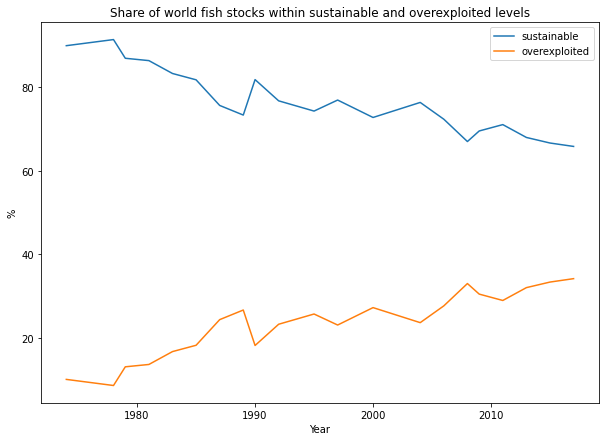

In [58]:
from operator import truediv

sus = sustainable_world['Share of fish stocks within biologically sustainable levels (FAO, 2020)'].tolist()
over = sustainable_world['Share of fish stocks that are overexploited'].tolist()
index = sustainable_world['Year']
df = pd.DataFrame({  'sustainable': sus,
    'overexploited': over}, index=index)
ax = df.plot.line(figsize=(10, 7))
ax.set_xlabel('Year')
ax.set_ylabel('%')
ax.set_title('Share of world fish stocks within sustainable and overexploited levels');

This was one of the first plots we made which clearly highlights the fact that we are on a rising trend of overfishing the oceans significantly

#### Country over-consumption

In this section we used a choropleth map to visualize where over consumption was taken place

In [59]:
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

In [60]:
df_consumption = get_consumption()

In [61]:
with open('data/countries-simplified.json') as response:
    countries = json.load(response)

# Limit output size due to notebook constraints
df_plot = df_consumption.query('Year == 2017')

range_color = (0, df_plot.consumption.quantile(0.99))
map_args = dict(
    geojson=countries,
    featureidkey='properties.ISO_A3',
    locations="Code",
    color="consumption",  # lifeExp is a column of gapminder
    hover_name="country",  # column to add to hover information
    # animation_frame='Year',  # left out due to notebook contraints
    mapbox_style="carto-positron",
    color_continuous_scale='Plasma',
    range_color=range_color,
    height=600
)
fig = px.choropleth_mapbox(df_plot,
                           zoom=0,
                           **map_args
                           )

fig

From the choropleth plot we got a more visual approach to evaluating which countries did over-consume fish. Here we see that especially the **Nordic** regions and **South East Asia** are regions to look out for. This plot serves as the main inspiration for focusing on these region whilst a more tabular approach helped decide which countries to focus within the two regions.

#### Countries with most impact

We select countries that have the most impact by finding the top 20 where we take population size into account.
By normalizing the values per capita, it becomes more representative of the countries. However, to avoid that the countries we select are too small to have any actual impact. We also take into account the absolute value of this top 20 list.

We will focus primarily on *Nordic* and *South East Asia* regions

In [62]:
df_population = pd.read_csv('data/population_total.csv')

In [63]:
df = get_industry_data()

In [64]:
df = add_population(df)

In [65]:
year = 2017

In [66]:
def group_by_elements(elements, year):
    df_production = df.query(f'Year == {year}').groupby(['Country Code', 'Element']).sum()['Value']
    df_production = df_production.reset_index().query(f'Element in {elements}').groupby('Country Code').sum().reset_index()
    df_production = pd.merge(df_population[['Country Code', f'{year}']], df_production, on='Country Code').rename({f'{year}': 'Population'}, axis=1)
    df_production[f'value_pr_capita_{year}'] = df_production.Value / df_production.Population * 1000
    df_production['Country'] = df_production.apply(lambda x: country_code_to_country[x['Country Code']], axis=1)
    df_production = df_production.set_index('Country')[['Country Code', 'Value', f'value_pr_capita_{year}']]
    return df_production

In [67]:
df.Element.unique().tolist()

['Production',
 'Import Quantity',
 'Domestic supply quantity',
 'Export Quantity']

In [68]:
df_production = group_by_elements(['Production'], year)
df_production.sort_values(by=f'value_pr_capita_{year}', ascending=False).head(20)

,Country Code,Value,value_pr_capita_2017
Country,,,
Iceland,ISL,2368.32,6.896680
Saint Kitts and Nevis,KNA,170.91,3.284457
Seychelles,SYC,272.36,2.841731
Kiribati,KIR,322.27,2.823141
Norway,NOR,7353.84,1.393573
Belize,BLZ,243.38,0.647675
St. Vincent and the Grenadines,VCT,65.81,0.599221
Maldives,MDV,286.52,0.577198
Namibia,NAM,1003.56,0.417693


Iceland tops the charts of production pr capita but with much less absolute value compared to Norway. China can be found further down with a significant amount compared to Norway

In [69]:
df_import = group_by_elements(['Import Quantity'], year)
df_import.sort_values(by=f'value_pr_capita_{year}', ascending=False).head(20)

,Country Code,Value,value_pr_capita_2017
Country,,,
Seychelles,SYC,155.36,1.620984
Norway,NOR,2444.88,0.463312
Denmark,DNK,2428.42,0.421237
Iceland,ISL,130.10,0.378858
Malta,MLT,169.93,0.363099
Mauritius,MUS,407.29,0.322067
Sweden,SWE,2149.17,0.213684
Netherlands,NLD,3308.55,0.193129
Portugal,PRT,1577.23,0.153125


Here we see that Seychelles in Africa tops the import pr capita but again with much less compared to Norway, Denmark, Sweden and the Netherlands. China is not even in the top 20 here, with respect to the value pr capita.

In [70]:
df_supply = group_by_elements(['Domestic supply quantity'], year)
df_supply.sort_values(by=f'value_pr_capita_{year}', ascending=False).head(20)

,Country Code,Value,value_pr_capita_2017
Country,,,
Saint Kitts and Nevis,KNA,174.25,3.348643
Kiribati,KIR,147.50,1.292125
Norway,NOR,3607.14,0.683563
Belize,BLZ,239.06,0.636179
St. Vincent and the Grenadines,VCT,67.39,0.613607
Iceland,ISL,206.38,0.600990
Malta,MLT,156.75,0.334937
Maldives,MDV,117.23,0.236161
Seychelles,SYC,21.31,0.222343


The supply in a country is highest for China and Norway in absolute value. With some smaller countries such as Saint Kitts and Nevis taking the lead in value per capita.

In [71]:
df_export = group_by_elements(['Export Quantity'], year)
df_export.sort_values(by=f'value_pr_capita_{year}', ascending=False).head(20)

,Country Code,Value,value_pr_capita_2017
Country,,,
Iceland,ISL,2292.04,6.674549
Seychelles,SYC,409.15,4.268961
Kiribati,KIR,177.46,1.554580
Norway,NOR,6209.57,1.176731
Denmark,DNK,3910.94,0.678396
Namibia,NAM,1085.86,0.451948
Maldives,MDV,182.24,0.367125
Mauritania,MRT,1526.24,0.356383
Peru,PER,9656.59,0.307101


Again the small country of Iceland (0.5 mil population) takes the in terms of export. However, Norway is still higher in terms of absolute values in the nordic region. China is nowhere to be found in the top 20 of exports.

#### Import / Export comparison

In this section we visualize the key points of the previous section

In [72]:
import matplotlib.pyplot as plt
import numpy as np

In [73]:
fish_Im = pd.read_csv("data/FAOSTAT_import.csv")
fish_Ex = pd.read_csv("data/FAOSTAT_export.csv")

fish_Im = fish_Im.drop(
    ["Domain Code", "Domain", "Area Code (FAO)", "Element Code", "Element", "Item Code", "Item", "Year Code", "Unit", "Flag", "Flag Description"],
    axis=1);
# These are not present in export and not notable countries
fish_Im = fish_Im.loc[fish_Im["Area"] != "Tajikistan"];
fish_Im = fish_Im.loc[fish_Im["Area"] != "Afghanistan"];

fish_Ex = fish_Ex.drop(
    ["Domain Code", "Domain", "Area Code (FAO)", "Element Code", "Element", "Item Code", "Item", "Year Code", "Unit", "Flag", "Flag Description"],
    axis=1);

In [74]:
# Sort on highest import values
Im_lastyear = fish_Im.loc[fish_Im["Year"] == 2019].sort_values("Value", axis=0, ignore_index=True, ascending=False)
Ex_lastyear = fish_Ex.loc[fish_Ex["Year"] == 2019]

Ex_lastyear = Ex_lastyear.set_index('Area');
Ex_lastyear = Ex_lastyear.reindex(index=Im_lastyear["Area"]);
Ex_lastyear.reset_index();

Im_lastyear = Im_lastyear.set_index('Area');

In [75]:
# ALTERNATIVELY
# Sort on highest export values
Im_lastyear = fish_Im.loc[fish_Im["Year"] == 2019]
Ex_lastyear = fish_Ex.loc[fish_Ex["Year"] == 2019].sort_values("Value", axis=0, ignore_index=True, ascending=False)

Im_lastyear = Im_lastyear.set_index('Area');
Im_lastyear = Im_lastyear.reindex(index=Ex_lastyear["Area"]);
Im_lastyear.reset_index();

Ex_lastyear = Ex_lastyear.set_index('Area');

In [76]:
# show only the top N countries (set 178 for all)
N = 20
plt.rcParams['figure.figsize'] = [5, 5 + (N * 70 / 178)]
y_axis = Im_lastyear[0:N].index
x_axis_Im = Im_lastyear["Value"][0:N]
x_axis_Ex = Ex_lastyear["Value"][0:N]

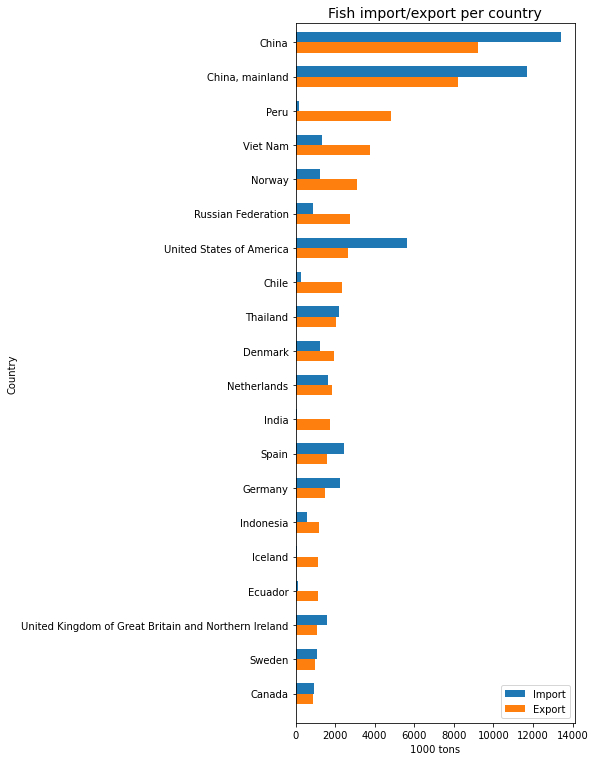

In [77]:
# Visualization
fig, ax = plt.subplots()

ind = np.arange(N)
width = 0.3

ax.barh(ind, x_axis_Im, width)  # IMPORT
ax.barh(ind + width, x_axis_Ex, width)  # EXPORT

ax.set(yticks=ind + width / 2, yticklabels=y_axis, ylim=[2 * width - 1, len(y_axis)])

plt.rcParams["legend.loc"] = 'lower right'
ax.legend(['Import', 'Export'])

plt.xlabel("1000 tons")
plt.ylabel("Country")
plt.title("Fish import/export per country", fontdict={'fontsize': 14})

# to show highest at the top
plt.gca().invert_yaxis()

plt.show()

In terms of impact it is evident that China is a significant contributor to the global import and export. Moreover, on 5th place we have the representative of the nordic region, Norway. Interestingly we find that Norway exports more than they import and vice versa for China.

# Data Analysis

In this section we will present our more detailed analysis and visualization in terms of fishing methods, correlations, historical trends and eating habits.

The key points and describing text will still exist on the website. This section serves to show how the plots "came alive"

### Capture fishery production and fishing gear

First we visualize and try to understand fishing methods in China and Norway better.

<AxesSubplot:title={'center':'Capture fisheries and aquaculture in China'}, xlabel='Year'>

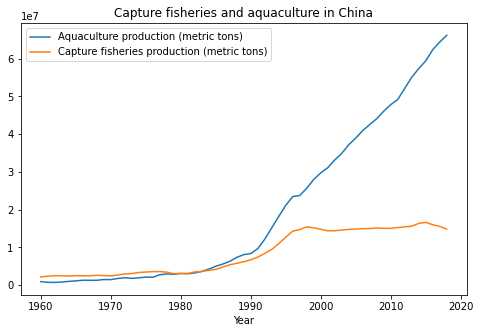

In [78]:
fish_prod = pd.read_csv('data/capture-fisheries-vs-aquaculture.csv')
fish_prod = fish_prod.set_index('Year')
fish_prod.query('Entity == "China"').plot(figsize=(8, 5), title='Capture fisheries and aquaculture in China')


<AxesSubplot:title={'center':'Capture fisheries and aquaculture in Norway'}, xlabel='Year'>

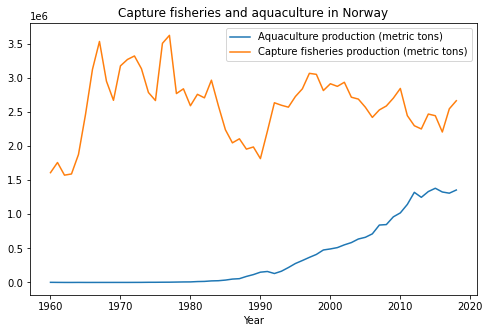

In [79]:
fish_prod.query('Entity == "Norway"').plot(figsize=(8, 5), title='Capture fisheries and aquaculture in Norway')


Generally, the trend of _aquaculture_ is still much on the rise. And it seems that China is better at focusing on aquaculture rather than capture fisheries. Though we should keep in mind that in terms of absolute numbers, China is still significantly ahead of Norway (10 times more). Norway seems to not focus as much on aquaculture and still has roots in traditional capture fishing methods.

Let's take a look at the top 10 capture fishery producers.

In [95]:
fish_prod_lastyear = fish_prod.query('Year == 2017')
fish_prod_lastyear = fish_prod_lastyear.sort_values("Capture fisheries production (metric tons)", axis=0, ascending=False)
fish_prod_lastyear.head()

,Entity,Code,Aquaculture production (metric tons),Capture fisheries production (metric tons)
Year,,,,
2017,IDA & IBRD total,NaN,1.041922e+08,71952300.38
2017,Low & middle income,NaN,1.035454e+08,68944889.73
2017,Middle income,NaN,1.027325e+08,66044865.73
2017,IBRD only,NaN,9.950129e+07,58935921.38
2017,East Asia & Pacific,NaN,9.373206e+07,40718597.78


In [81]:
fish_prod_lastyear_country = fish_prod_lastyear.loc[fish_prod_lastyear["Code"].notnull()]
fish_prod_lastyear_other = fish_prod_lastyear.loc[fish_prod_lastyear["Code"].isnull()]

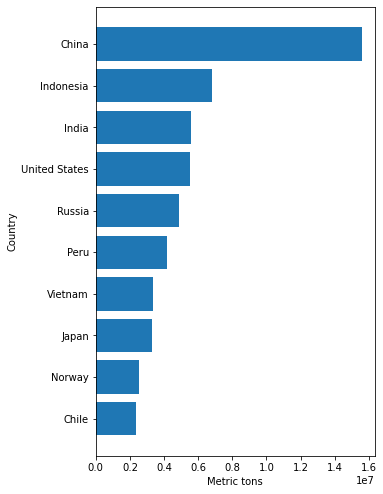

In [82]:
# show only the top N countries (set 215 for all)
N = 10

plt.rcParams['figure.figsize'] = [5, 5 + (N * 70 / 215)]

fig = plt.figure()

y_axis = fish_prod_lastyear_country["Entity"][0:N]
x_axis = fish_prod_lastyear_country["Capture fisheries production (metric tons)"][0:N]
plt.barh(y_axis, x_axis, height=0.8)

plt.xlabel("Metric tons")
plt.ylabel("Country")
plt.title("", fontdict={'fontsize': 14})

# to show highest at the top
plt.gca().invert_yaxis()

plt.show()

Again we see China as a major factor in production through capture fisheries. And yet again, the closest rival in the nordic and european region is Norway.

The key problem of capture fisheries isn't that we capture fish in the wild. It's about *how* we do it. Therefore, we further investigate which methods each country uses for capture fishery

In [83]:
@style_plot
def plot_fishing_type(df, country):
    methods = ['longline', 'gillnet', 'small_scale', 'purse_seine', 'pelagic trawl', 'bottom_trawl', 'gear']

    df_plot = pd.melt(df.reset_index(), ['Year', 'Entity'], methods, var_name='Fishing Type', value_name='Tonnes')

    fig = px.area(df_plot.query(f'Entity == "{country}"'), x='Year', y='Tonnes', color='Fishing Type')

    fig.update_layout(
        title=dict(
            text=f'Amount of fish caught by fishing type from 1950 to 2018<br><sup>{country}</sup>'
        ),
        xaxis=dict(
            showgrid=False
        ),
        yaxis=dict(
            showgrid=False
        ),
    )

    return fig

In [84]:
from plots.data import get_fishing_types

df_fish_methods = get_fishing_types()

fig = plot_fishing_type(df_fish_methods, 'Norway')
fig.show()


In [85]:
fig = plot_fishing_type(df_fish_methods, 'China')
fig.show()

It's very clear from these plots that they have a significant proportion of bottom trawling in China compared to Norway. This is a big motivator for our story as our research shows that bottom trawling is one of the methods with the highest impact on the environment. And taking China's numbers into account, this effect is worsened by almost a factor of 10 compared to Norway.

## Global consumption trend

We wanted to analyse the global trend and make a simple linear regression to describe the current trend.

In [86]:
df = get_consumption()

In [87]:
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

df_agg = df.groupby(["Year"]).mean().reset_index()

lr = LinearRegression()
lr.fit(df_agg['Year'].values.reshape(-1, 1), df_agg['consumption'])

df_preds = pd.DataFrame(df_agg['Year'].copy())

df_preds['consumption'] = lr.predict(df_agg['Year'].values.reshape(-1, 1))

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_preds['Year'], y=df_preds['consumption'],
               name='Trend')
)
fig.add_trace(
    go.Scatter(x=df_agg['Year'], y=df_agg['consumption'],
               name='Consumption')
)

equation = f"Consumption = {lr.coef_[0]:.2f} * Year - {abs(lr.intercept_):.2f}"

fig.add_annotation(
    x=1994,
    y=df_preds.query('Year == 1994')['consumption'].iloc[0],
    text=equation,
    font=dict(
        size=13
    ),
    ax=-100,
    ay=-60,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    borderwidth=2,
    bordercolor="#c7c7c7",
    borderpad=4,
    arrowcolor='#c7c7c7'
)

fig.update_layout(
    title='Average global fish-seafood consumption from 1967 to 2017',
    xaxis=dict(
        title='Year',
        showgrid=False
    ),
    yaxis=dict(
        title='Fish-seafood (kg / capita)',
        showgrid=True),
)

The plot above shows the average global consumption of fish and seafood from 1967 to 2017. Moreover, on top of the consumption line, there's a trend line found with linear regression. The coefficient shows that there is a 0.12 kg / capita increase per year on the global average. It clearly shows that there is a steady increase. Comparing this to the plot on sustainability and over-fishing, we see that the trend in both plots is that eating more results in more overexploitation of fish.

## GDP vs Consumption

Finally, we analyse the relationships between a country's GDP and it's consumption

In [88]:
from plots.data import get_gdp

df_gdp = get_gdp()

In [89]:
df_gdp = df_gdp.query('["Norway", "China"] in `Country Name`')

df_plot = pd.merge(df_gdp,
                   df_consumption.rename({'Code': 'Country Code'}, axis=1)[['consumption', 'Country Code', 'Year']],
                   on=['Country Code', 'Year'])

After merging the gdp and consumption data, we plot an inital plot

In [90]:
fig = px.scatter(df_plot,
                 x='gdp_pr_capita',
                 y='consumption',
                 color='Country Code',
                 hover_name='Year')

fig.show()

The x axis is definitely out of proportion. It looks like there's some kind of log(x) relation. Let's try to log the x axis.

In [91]:
fig = px.scatter(df_plot,
                 x='gdp_pr_capita',
                 y='consumption',
                 color='Country Code',
                 log_x=True,
                 hover_name='Year')
fig.update_layout(
    xaxis=dict(
        title='log(gdp_pr_capita)'
    )
)
fig.show()

Here we get a much more linear line! Great, this we can use for fitting a linear trendline.

In [92]:
fig = px.scatter(df_plot,
                 x='gdp_pr_capita',
                 y='consumption',
                 color='Country Code',
                 log_x=True,
                 hover_name='Year',
                 trendline='ols',
                 trendline_options=dict(log_x=True),
                 trendline_scope='overall')

df_plot['gdp_pr_capita_log'] = np.log(df_plot['gdp_pr_capita'])
corr = df_plot[['gdp_pr_capita_log', 'consumption']].corr().iloc[0, 1]

fig.add_annotation(text=f"Pearson-Spearman correlation: {corr:.2f}",
                   xref="paper", yref="paper",
                   x=0.1, y=0.95,
                   showarrow=False,
                   bordercolor="#c7c7c7",
                   borderwidth=2,
                   borderpad=10,
                   font=dict(
                       size=15
                   )
                   )

fig.update_layout(
    title=dict(
        text='Consumption vs GDP pr capita from 1961 to 2017'
    ),
    xaxis=dict(
        title='Log(GDP / capita)'
    ),
    yaxis=dict(
        title='Fish-seafood (kg / capita)'
    )
)


It's quite clear that when looking at a country's log(GDP) and their fish-seafood consumption, that the more GDP you have, the more likely it is that you will consume more fish and seafood in the country. There is a slight overlap between the two countries at log(gdp) = [2 - 3] but generally the trendline follows the points closely and the Pearson-Spearman correlation shows a strong correlation between the two variables, consumption and GDP

## Protein supply and emissions

In this section, we will cover our analysis for the protein supply and emissions in Norway and China

In [96]:
from plots.data import get_protein

protein = get_protein()

In [97]:
protein_sum = protein.sum(axis=1)

protein_cds = {'countries': list(protein.index.values)}

# Calculate fraction so we get range from 0 to 100%
for food in list(protein.columns):
    protein_cds[food] = list((protein[food].values / protein_sum) * 100)

df_plot = pd.DataFrame.from_dict(protein_cds)
df_plot = pd.melt(df_plot, ['countries'], df_plot.columns[1:],
                  var_name='Protein source',
                  value_name='Protein amount')
df_plot = df_plot.sort_values('Protein source', ascending=False)

fig = px.bar(df_plot,
             x='Protein amount',
             y='countries',
             color='Protein source',
             orientation='h')

fig.update_layout(
    title='Distribution of protein sources<br><sup>China vs Norway</sup>',
    xaxis=dict(
        title='Protein distribution (%)',
        showgrid=True
    ),
    yaxis=dict(
        title='Country'
    ),
    width=1200
)

In general, it's clear that there are cultural differences in terms of where the two countries get their protein from. The first thing we notice, is that they eat much more pork in China than Norway. And since people in Asia tend to be lactose intolerant, it's no surprise that they drink more milk in Norway than China. However, the most interesting thing is that they eat the _same_ amount of fish and seafood with respect to their population size.

Let's take a look at the GHG emissions from eating these types of food.

In [98]:
from plots.data import get_protein_ghg

df_ghg = get_protein_ghg()

In [99]:
df_ghg = df_ghg.sort_values('Protein source', ascending=False)

fig = px.bar(df_ghg,
             x='Protein source',
             y='Emissions',
             color='Protein source',
             )

fig.update_layout(
    title='Protein source GHG emissions per 100g protein from 2017',
    xaxis=dict(
        title='Protein source'
    ),
    yaxis=dict(
        title='GHG emissions pr 100g protein'
    )
)


It's very clear that eating "Beef" and "Lamb & Goat" produces a lot of Greenhouse Gasses. Compared to Fish and Seafood, Beef emits 20 times more GHG and "Lamb & Goat" emits 4 times more. Out of all the options, Fish and Seafood is only beaten by Poultry (slightly) and Eggs.

This motivates a shift towards more Fish and Seafood as a primary protein source. But are there specific types of fish that we should eat, in order to still be considerate towards the environment?

In [93]:
from plots.data import get_aquaculture_emissions

df_aqua_emissions = get_aquaculture_emissions()

In [94]:
fig = px.bar(df_aqua_emissions,
                 x='Amount',
                 y='Entity',
                 color='Greenhouse Gas',
                 orientation='h',
                 )

fig.update_layout(
    title='Emissions from aquaculture farming different species',
    xaxis=dict(
        title='Amount (kg / tonne edible weight)'
    ),
    yaxis=dict(
        title='Farmed species'
    ),
    width=800,
)

The emissions from aquaculture shows that we should be focusing on environmentally friendly species such as Seaweed and Bivalves. However, these tend not to provide enough protein, fats and vitamins as traditional fish. Thus other alternatives lie on Salmon, Trout and Shrimp.

# Genre

This section will cover how we followed the philosophy of [Segal and Heer](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf) on _Narrative Visualization_

## Which genre

The authors present seven genres:

* Magazine Style
* Annotated Chart
* Partitioned Poster
* Flow Chart
* Comic Strip
* Slide Show
* Film/Video/Animation

From these, our paper mainly follows the **Magazine Style** genre. However, as the authors emphasize, these are basic genres and the tradeoffs between author-driven and reader-driven stories require context-specific consideration and judgement.

Our story is told through a sequence of topic that each contribute to a developing story where initially the reader is presented to a broad subject but guided towards a specific conclusion towards the end. This way of telling a story is primarily author-driven and fits the magazine style genre. Due to the author-driven nature of this genre, we realized that we had to make the layout of the website pleasing to look at whilst communicating the results efficiently and keeping the reader engaged. This shifted our focus to adopting some more reader-driven approaches.

Moreover, our data is indeed very complex as it originates from 11 different files and covers a wide variety of perspectives all from global fishing industries to greenhouse gas emissions from farmed agricultural fish. Therefore, to balance the author-driven and reader-driven aspects, we have taken inspiration from the "Interactive Slideshow" which emphasizes that complex datasets is often well-suited for this format, as _it allows the author to draw discrete boundaries between story segments_.


## Visual Narrative

The visual narrative is split into three main components

1) Visual Structuring
2) Highlighting
3) Transition Guidance

Each component contributes to different parts of the visual narrative. The visual structuring (1) refers to mechanisms that communicate the overall structure of the narrative to the reader. The highlighting (2) draws attention to specific components of a narrative through use of color, motion, framing, size and more. Finally, transition guidance (3) touches upon how the reader is guided from one part of a visualization to either another part or entirely different visualization, without disorienting the reader.


We make use of the following techniques from the visual narrative:

### Visual Structuring
* **Progress Bar / Timebar**
* **Consistent Visual Platform**

We made use of the progress bar as it gives the reader a nice way of interacting with the graph and seeing the development over time. We chose to go with a consistent visual platform to make the aesthetics feel more connected and in a flow, which would also help guide the flow of the content (story). This can be seen in using the same color scheme across all plots and also using the same plotting backend (plotly). Having too many inconsistencies can result in disorientation.

### Highlighting
* **Feature Distinction**

We make use of feature distinction because it clearly showcases where and what the reader should be trying to look at or interact with. For example, the reader is initially met with
a section of "Tabs" that indicate a slight blue color when hovered over, telling the reader to click each tab. Then under the "Industry" tab, colors are used to highlight four buttons that describe different areas of the fishing industry.

### Transition Guidance
* **Familiar Objects**
* **Object Continuity**

The transition guidance is important to make sure the reader feels compelled to continue reading the story. There are a bunch of strategies that one can use, for example encourage the use of reader-driven designs. Another strategy is to make the transition between content smooth and seamless. Since the magazine style genre is inherently linear, we try our best to create a more encouring journey through our story by using the transition guidance principles. For this reason, we chose to focus a lot on Familiar Objects and Object Continuity. We ensure this by creating plots that originate from the same backend (plotly), using the same color schemes (`@style_plot` decorator), and roughly the same font and sizes. Whilst all being structured in the familiar two column layout with a few exceptions to keep the design from being too repetitive.

## Narrative Structure

The narrative structure of a visualization is more concerned about the content and message that each visualization brings to the narrative. This division is broken into three parts:

1. Ordering
2. Interactivity
3. Messaging

The ordering (1) is concerned on which path the reader can take through the narrative, such as a linear (author-driven) path, user-chosen or a random path. The interactivity (2) is concerned about ways that the reader can select, search and navigate each visualization, and also how the reader learns about these interactions. The final section, messaging (3) is about the ways a visualization communicates observations and results to the reader.

We have structured our story according to the following categories:

### Ordering
* **Linear**

As the story tries to follow the Interactive Slideshow format, it is primarily a linear path that the reader is forced to take. However, in the absolute beginning of the story we try to let the reader make some choices by viewing the different tabs. Each tab will then present some accompanying text to describe the plot. This will make the path seem less linear whilst still ensuring that the reader will progress naturally to the next chapter below once all tabs have been explored.

### Interactivity
* **Hover Highlighting**
* **Filtering / Selection / Search**

In terms of interactivty, all the plots have the option to provide more detailed information when hovering. Moreover, the filtering and selection functionalities have been implemented as the reader can optionally add or remove groups from plots, and also zoom in / select specific points of the plots that they want to further enhance. This ensures that each chapter has some sort of depth to it (additional information can be retrieved by interacting with the plots), and in turn reduces the static feel of the magazine genre. However, this is hard to enforce when we also have to make sure that the reader does not get lost in the different datasets.

### Messaging
* **Captions / Headlines**
* **Annotations**
* **Accompanying Article**

In terms of messaging, we try as much as possible to keep the visualizations informative on their own. However, the reader must be guided to some extent as the authors argue is a property of an "Interactive Slideshow". Therefore, we provide captions and headlines for each section while annotating some plots where necessary (trend lines). Moreover, every plot has an accompanying article as much of the information can only be explained by associating the plots with our research, such as what effect Phosphorous and Nitrogen has on the ocean environments.


# Visualizations

This section will cover the visualization techniques we used on the website and why

## Choropleth maps

The two main choropleth maps: global fish consumption and global fishing industry (has four parts) are some of the first plots that are presented to the reader. Our story starts from a birds-eye view of the problem and has yet to dive into Norway and China specifically. The best way to give the reader this birds-eye overview is to do exactly that: give them a birds-eye overview. This is best done as a choropleth map that enables a high level of interactivity whilst still giving plenty of information in terms of hover actions and colors aligned by a colorbar.

Moreover, one of the first topics that we communicate to the reader is the historical development. This goes well with having a multi-dimensional choropleth map of consumption, that shows the progression over time from 1961 to 2017.

## Line and trendline plots

Line and trendline plots are used to show how factors such as average global fish consumption and fish production types develop over time, either individually or by comparing development across groups. Given the nature of line plots, it's intuitive for the reader to have time as an x-axis component and a variable on the y-axis. Different colors on the graph can indicate multiple groups within the same year, or the existence of a trend such as the average global fish consumption trend.

Interestingly, the GDP vs consumption plot differs from the other line and trendline plots in terms of what is on the axis. In this plot, we use the two variables: GDP pr capita and consumption (kg / capita) as axes. Moreover, an overall trend is used along with a textbox of the Pearson-Spearman correlation to truly emphasise and communicate the correlation between GDP and seafood consumption. Finally, we separate the points by nation (China vs Norway) to further show where the two countries lie on the trend.

Overall, the line and trendline plots shows both development over time and how variables correlate with one another.

## Area plots

We make use of area plots when we want to show how one metric is separated into smaller components. The first example is the 'Overfishing' tab which shows an area plot of global overexploited fishing vs sustainable fishing. Of course the sum of those should always be 100% which is why we use the area beneath the curve to show that the sum across variables add to 100%.

This method is repeated for the 'Fishing Methods' section where the two area plots show the proportion of each fishing method. The area plots are similar to line plots in the way that they are both essentially lines and has an intuitive interpretation with time on the x-axis. However, the area plots are better at showing proportions of groups. Which is very similar to a vertical stacked bar chart. We chose to maintain the area plot for the fishing methods as it has good aesthetics without losing the message (clearly more bottom trawling in China) and most importantly; we are able to intuitively add a time-dimension.

## Bar plots
Bar plots are excellent at comparing two or more groups against each other as the scale of the bar often make is much easier to understand how groups compare in terms of size. There are multiple ways of utilizing this feature. We chose to plot both vertical and horizontal bar plots.

### Vertical

The only vertical bar plot we have is the one on Protein source GHG emissions. This plot highlights the worst protein sources in terms of GHG emissions by showing how Beef and Lamb & Goat compare to other protein sources. Moreover, it also shows how little Fish and Seafood emits compared to the other sources. And due to plotly's interactivity, the reader can deselect the Beef group and look at how the groups compare without such a significant outlier. We deem that these insights are best communicated in a vertical bar plot.

### Horizontal

There are two, although different, bar plots in the story.

The first is the distribution of protein sources between Norway and China. It shows the distribution of protein from 0% to 100%, and since it's important to highlight how the countries compare, we chose to make the plot horizontal, as that will lead to a more natural direction of reading (left to right). In addition, by having the bars stacked on top of each other it is visually much easier to compare them. We believe that this layout makes the reader infer the differences between two countrys' protein sources, as seamlessly as possible.

The second horizontal bar plot is slightly different as there are more groups to compare and the fact that they do not function as smaller components of one whole. Instead, the plots highlights how much GHG each farmed species emits per kg of edible weight. Chicken is included here as a baseline comparison, as it's known to be more environmental friendly than most alternatives. This plot is horizontal due to us wanting to highlight _negative_ emissions from the Seaweed and Bivalves species, this is yet again best shown horizontally, as we should find the negative values first due to reading left to right. Moreover, each bar consists of both the Nitrogen and Phosphorous emissions which serves as an extra comparison between which GHG each species emits.

# Discussion

Finally, we discuss the overall process and the final product.

Let's start with the things that went well. Considering the vast amount of data, we believe that the true key points have been extracted from each dataset to create a story that teaches the reader something about where overfishing takes place, how it damages the environment and how the industry can be more sustainable. The plots used in the website all follow the same theme, are easy to read and have a general aesthetic pleasing look to them. Moreover, the website itself is filled with small details such as a nice but subtle background with a turtle (:turtle:), a navigation bar that follows you around the page so you can always jump around, and other things such as making use of markdown language to highlight quotes, create titles and mark words in bold or italic. Moreover, given that the topic is difficult to generate something novel from, we find that the angle on emissions with respect to what they eat, and also how the two countries farm the fish, provides insights that have not been discussed much before.

Now to what could've been improved. First of all, if not obvious by now, we would've chosen a smaller dataset, preferably 1 or 2 with many columns that can be engineered in different ways to create novel insights or facilitate some more advanced machine learning that fitting a regression line. Moreover, the many datasets come as a consequence of having a very broad topic that was initially difficult to narrow down to a completely clear story. Much of our time was spent jumping through datasets and spending hours analysing them only to find out that they were not really valuable.

By having a more narrow scope and smaller dataset, it would've been easier to guide the reader and create a seamless flow in the story. Perhaps less complexity in the story would have lead to more creative plotting techniques that would not require accompanying text.


# Website (Optional)

As this section is not required, we will just briefly go over the basics behind the website for interested readers.

The website is written using the plotly `Dash` framework and is hosted on the 'Heroku' cloud.

Dash is a framework that enables python users (with some html and css knowledge) to create website that seamlessly integrate with a Python backend to perform tasks on callbacks (callbacks often occur after user-interaction).

The website structure is done using simple HTML components and a `style.css` stylesheet. For the plotting features, the integrated dash components are used to render them.

# Contributions

## Website
| **Responsibility**                 | **Responsible** |
|------------------------------------|-----------------|
| Introduction                       | Yufan           |
| GDP and Consumption                | Niels           |
| Protein Intake                     | Niels           |
| Fishing Methods                    | Simon           |
| Aquaculture and Capture production | Yufan           |
| Aquaculture Emissions              | Niels           |
| Website coding and creation        | Simon           |

## Explainer notebook


# References


